In [8]:
from ga_lib import ga
import numpy as np
from matplotlib import pyplot as plt
import os 
from PyLTSpice import SimRunner, SpiceEditor, LTspice ,RawRead
import math
# import eval_interface_parallel_proc

In [9]:
R_1 = [10,15,22,33,47,68,100,220,330,470,1e3,1.5e3,2.2e3,3.3e3,4.7e3,5.6e3,6.8e3,8.2e3,10e3,15e3,22e3,33e3,47e3,56e3,68e3,100e3,150e3,220e3,330e3,470e3]
R_2 = [10,15,22,33,47,68,100,220,330,470,1e3,1.5e3,2.2e3,3.3e3,4.7e3,5.6e3,6.8e3,8.2e3,10e3,15e3,22e3,33e3,47e3,56e3,68e3,100e3,150e3,220e3,330e3,470e3]
R_3 = [10,15,22,33,47,68,100,220,330,470,1e3,1.5e3,2.2e3,3.3e3,4.7e3,5.6e3,6.8e3,8.2e3,10e3,15e3,22e3,33e3,47e3,56e3,68e3,100e3,150e3,220e3,330e3,470e3]
R_4 = [10,15,22,33,47,68,100,220,330,470,1e3,1.5e3,2.2e3,3.3e3,4.7e3,5.6e3,6.8e3,8.2e3,10e3,15e3,22e3,33e3,47e3,56e3,68e3,100e3,150e3,220e3,330e3,470e3]
C_1 = [1e-6,2.2e-6,3.3e-6,4.7e-6,6.8e-6,10e-6,15e-6,22e-6,33e-6,47e-6,68e-6,100e-6,150e-6,220e-6,330e-6,470e-6,680e-6,1e-3,1.5e-3,2.2e-3,3.3e-3,4.7e-3,10e-3,20e-3,100e-3]
L_1 = [0.1e-6,0.22e-6,0.47e-6,1e-6,2.2e-6,3.3e-6,4.7e-6,10e-6,22e-6,33e-6,47e-6,100e-6,220e-6]
search_space = [R_1,R_2,R_3,R_4,C_1,L_1]

In [10]:
n_generations = 1
n_spawn = 10
n_comp = len(search_space)
n_parents = 5
n_kids = 2
fitness_val = []
req_gain = 25
gen = 0
n_families = 10

In [11]:
def fitness_eval(v_in , v_out , req_gain):
    gain = v_out/(v_in + 1e-10)
    fitness_val_2 = -np.var(gain)
    fitness_val_1 = np.mean(-abs(gain - req_gain))
    print(f"variance in gain = {fitness_val_2}")
    print(f"avg gain = {fitness_val_1}")
    print(f"shape of the input voltage : {v_in.shape}")
    print(f"shape of th output voltage : {v_out.shape}")
    return 0.9*fitness_val_1 + 0.1*fitness_val_2

def sim_runner(param_lst , netlist , folder_path , gen , id):
    net = SpiceEditor(netlist)
    runner = SimRunner(output_folder=folder_path, simulator=r"E:\LTspice\LTspice.exe")
    net.set_component_value('R1',param_lst[0])
    # net.set_component_value('R2',param_lst[1])
    net.set_component_value('R3',param_lst[1])
    net.set_component_value('R4',param_lst[2])
    net.set_component_value('R5',param_lst[3])
    net.set_component_value('C1',param_lst[4])
    net.set_component_value('L1',param_lst[5])
    run_netlist_file = "{}_{}.net".format(gen,id)
    raw , log = runner.run_now(net , run_filename = run_netlist_file)
    raw_file_name = "{}_{}.raw".format(gen,id)
    return raw_file_name , folder_path

def val_extracter(raw_file , folder_path):
    cwd = os.getcwd()
    os.chdir(folder_path)
    raw = RawRead(raw_file)
    v_out = raw.get_trace('V(v_out)')
    v_in = raw.get_trace('V(v_in)')
    time = raw.get_axis()
    os.chdir(cwd)
    return np.array(v_in), np.array(v_out),np.array(time) 

In [16]:
def eval_interface(param_lst , netlist , folder_path , gen , id , req_gain):
    raw_file , folder_path = sim_runner(param_lst , netlist , folder_path , gen , id)
    v_in, v_out ,time = val_extracter(raw_file , folder_path)
    # v_in = v_in[time > 0.02]
    # v_out = v_out[time > 0.02]
    fitness_val = fitness_eval(v_in , v_out , req_gain)
    return fitness_val

In [11]:
cwd = os.getcwd()
dir = "ga_optim_volt_boost"
try:
    os.mkdir(dir)
except:
    print("folder already exist")
folder_path = os.path.join(cwd,dir)

folder already exist


In [12]:
volt_boost = ga(n_generations,n_spawn,n_comp,search_space,n_parents,n_kids,n_families)

In [13]:
loss_generation = []
pop_storage = []

In [ ]:
# volt_boost.fitness_val = []
for gen in range(n_generations):
    print("//"*50)
    print(f"generation : {gen}")
    volt_boost.spawn()
    netlist = 'voltage_boost.net'
    os.chdir(cwd)
    fitness_val = []

    temp_pop = []
    for i in volt_boost.population:
        if i not in temp_pop:
            temp_pop.append(i)

    if(len(temp_pop) >= 3):
        volt_boost.population  = temp_pop
    else:
        volt_boost.population  = volt_boost.population[:3]

    for i in range(len(volt_boost.population)):
        param_lst = volt_boost.population[i]
        id = i
        print(f"mutant : {i}")
        fitness_val.append(eval_interface(param_lst , netlist , folder_path , gen , id , req_gain))
    volt_boost.fitness_score = fitness_val
    temp = 1- pow(1.2,max(fitness_val))
    print("##"*50)
    print(f"prob of mutation : {temp}")
    volt_boost.pipeline(fitness_score = fitness_val,sa_temp= temp)
    fitness_val = []
    # volt_boost.fitness_val = []
    os.chdir(cwd)

    temp_pop = []
    for i in volt_boost.population:
        if i not in temp_pop:
            temp_pop.append(i)

    if(len(temp_pop) >= 3):
        volt_boost.population  = temp_pop
    else:
        volt_boost.population  = volt_boost.population[:3]

    for i in range(len(volt_boost.population)):
        param_lst = volt_boost.population[i]
        id = i
        print(f"mutant : {i}")
        fitness_val.append(eval_interface(param_lst , netlist , folder_path , gen , id , req_gain))
    volt_boost.fitness_score = fitness_val
    volt_boost.fitness_sorter()
    loss_generation.append(fitness_val)
    pop_storage.append(volt_boost.population)

////////////////////////////////////////////////////////////////////////////////////////////////////
generation : 0
initial spawn done sucessfully
mutant : 0
variance in gain = -1.6982922554016113
avg gain = -19.686134338378906
shape of the input voltage : (1888538,)
shape of th output voltage : (1888538,)
mutant : 1
variance in gain = -8.173796231858432e-06
avg gain = -24.130460739135742
shape of the input voltage : (31902,)
shape of th output voltage : (31902,)
mutant : 2
variance in gain = -1.1323088955350613e-07
avg gain = -24.13221549987793
shape of the input voltage : (3432,)
shape of th output voltage : (3432,)
mutant : 3
variance in gain = -4.485696626943536e-05
avg gain = -24.06621742248535
shape of the input voltage : (78901,)
shape of th output voltage : (78901,)
mutant : 4
variance in gain = -0.014971933327615261
avg gain = -23.773563385009766
shape of the input voltage : (89874,)
shape of th output voltage : (89874,)
mutant : 5
variance in gain = -1.1420306367249111e-10
av

In [18]:
volt_boost.population

[[470.0, 330.0, 33.0, 1500.0, 0.1, 3.3e-06],
 [33000.0, 68000.0, 220000.0, 47.0, 0.00047, 1e-07],
 [33000.0, 68000.0, 33, 56000.0, 3.3e-05, 3.3e-06],
 [4700.0, 22.0, 15000.0, 33000.0, 6.8e-06, 0.0001],
 [33000.0, 68000.0, 220000.0, 220000.0, 6.8e-05, 4.7e-05],
 [10000.0, 3300.0, 330000.0, 470000.0, 0.0001, 2.2e-05],
 [1000.0, 3300.0, 22.0, 22000.0, 0.001, 1e-07],
 [5600.0, 470.0, 5600.0, 68.0, 0.0047, 4.7e-07],
 [22.0, 22000.0, 2200.0, 22.0, 0.0001, 3.3e-06],
 [220.0, 33.0, 330000.0, 47000.0, 0.0047, 1e-07],
 [22000.0, 100000.0, 33000.0, 68000.0, 1e-06, 1e-07],
 [5600.0, 470, 56000.0, 150000.0, 1.5e-05, 4.7e-07],
 [100000.0, 10, 2200.0, 33000.0, 0.0015, 1e-05],
 [47.0, 56000.0, 330000.0, 1000.0, 4.7e-06, 0.00022],
 [10.0, 4700.0, 100000.0, 3300.0, 0.0015, 4.7e-06],
 [330.0, 10000.0, 33000.0, 220000.0, 0.00068, 1e-05],
 [6800.0, 470, 470, 1000.0, 0.0015, 0.0001],
 [3300.0, 68, 1000.0, 330, 0.0015, 0.00022],
 [33, 8200.0, 6800.0, 330000.0, 1e-06, 0.0001],
 [2200.0, 33.0, 33000.0, 47000.0

In [19]:
volt_boost.fitness_val

[-10.561914014816285]

In [20]:
loss_generation

[[]]

In [35]:
mutants = []
generation_lst = []
gen_val = 0
for i in loss_generation:
    mutants += i
    gen_val += 1
    lst = [gen_val for num in range(len(i))]
    generation_lst += lst

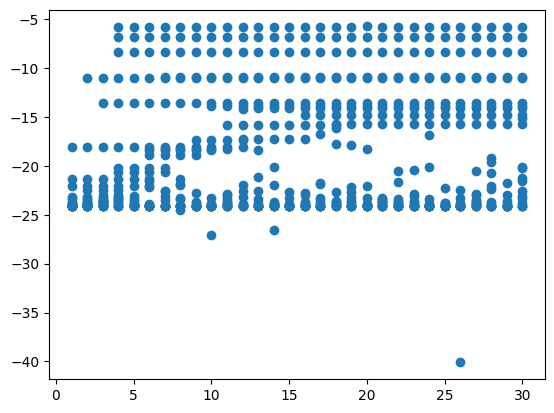

In [36]:
plt.scatter(generation_lst ,mutants )
plt.show()

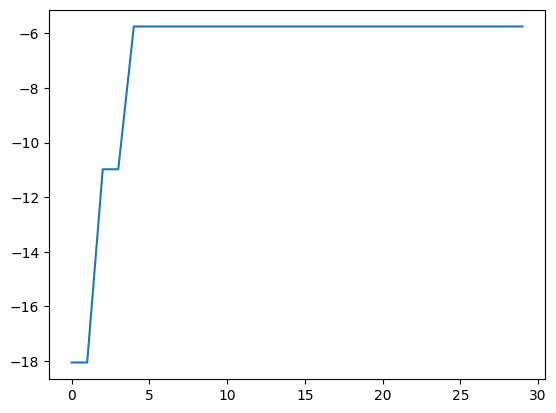

In [38]:
plt.plot(volt_boost.fitness_val)
plt.show()

In [40]:
time

CPU times: total: 0 ns
Wall time: 0 ns


# Version 2.0

In [1]:
from ga_lib import ga
import numpy as np
from matplotlib import pyplot as plt
import os 
from PyLTSpice import SimRunner, SpiceEditor, LTspice ,RawRead
import os

In [2]:
R_3 = [1e3,1.2e3,1.33e3,1.5e3,2e3,2.2e3,2.5e3,2.67e3,3e3,3.3e3,3.5e3,3.7e3,4e3,4.5e3,4.7e3,5.6e3]
R_4 = [10,22,47,69,79,100,110,122,147,169,200,210,322,350,372,300]
R_5 = [1e3,1.2e3,1.33e3,1.5e3,1.8e3,2e3,2.2e3,2.33e3,2.5e3,2.8e3,3e3]
# R_4 = [10,22,47,100,330,470,1e3,1.5e3,2.2e3,3.3e3,4.7e3,5.6e3,6.8e3,8.2e3,10e3,15e3,22e3,33e3,47e3,56e3,68e3,100e3,150e3,220e3,330e3,470e3]
C_1 = [1e-6,3.3e-6,6.8e-6,9.9e-6,15e-6,22e-6,30e-6,33e-6,37e-6,39.9e-6,47e-6,55e-6,60e-6,66e-6,72e-6,87e-6,100e-6]
# C_1 = [47e-12,220e-12,0.1e-6,0.47e-6,1e-6,3.3e-6,6.8e-6,15e-6,22e-6,33e-6,47e-6,100e-6,330e-6,470e-6,680e-6,1000e-6]
C_2 = [1e-9,10e-9,33e-9,66e-9,0.05e-6,0.083e-6,0.1e-6,0.2e-6,0.3e-6,0.47e-6,0.54e-6,0.77e-6,1e-6,1.05e-6,1.1e-6,1.2e-6] #[1e-6,2.2e-6,3.3e-6,4.7e-6,6.8e-6,10e-6,15e-6,22e-6,33e-6,47e-6,68e-6,100e-6,150e-6,220e-6,330e-6,470e-6,680e-6]
L_1 = [0.1e-3,0.22e-3,0.47e-3,0.69e-3,0.79e-3,0.89e-3,1e-3,1.1e-3,1.2e-3,1.3e-3,1.4e-3,1.5e-3,1.72e-3,1.82e-3,2e-3]
# L_1 = [2.2e-6,6.8e-6,100e-6,150e-6,220e-6,330e-6,470e-6,680e-6,0.1e-3,0.22e-3,0.47e-3,1e-3,10e-3,20e-3,30e-3]
search_space = [R_3,R_4,R_5,C_1,C_2,L_1]

In [3]:
len(R_3)*len(R_4)*len(R_5)*len(C_1)*len(C_2)*len(L_1)

11489280

In [4]:
#input = 5v
n_generations = 30 
n_spawn = 20
n_comp = len(search_space)
n_parents = 2
n_kids = 2
fitness_val = []
req_output = 90
gen = 0
n_families = 25
population_tracker = [] #tracks the top n_spawn members of the population in each iteration
fitness_tracker = [] #tracks the fitness of the top n_spawn members of the popuklation in each iteration

In [5]:
cwd = os.getcwd()
dir = "ga_optim_volt_boost"
try:
    os.mkdir(dir)
except:
    print("folder already exist")
folder_path = os.path.join(cwd,dir)

folder already exist


In [6]:
volt_boost = ga(n_generations,n_spawn,n_comp,search_space,n_parents,n_kids,n_families)
loss_generation = [] #loss of a generation or the mutans n kids of that generation
pop_storage = [] # Temporary storage of the population being evaluated in the order 
os.chdir(cwd)

In [7]:
def sim_runner_v2(param_lst_lst , netlist , folder_path , gen):
    net = SpiceEditor(netlist)
    global pop_storage
    global loss_generation
    id = 0
    cwd = os.getcwd()
    runner = SimRunner(output_folder=folder_path, simulator=r"E:\LTspice\LTspice.exe")
    netlist_new = "buff_netlist.net"
    for param_lst in param_lst_lst:
        net.set_component_value('R1',1e3)
        net.set_component_value('R2',1e3)
        net.set_component_value('R3',param_lst[0])
        net.set_component_value('R4',param_lst[1])
        net.set_component_value('R5',param_lst[2])
        net.set_component_value('C1',param_lst[3])
        net.set_component_value('C2',param_lst[4])
        net.set_component_value('L1',param_lst[5])
        net.save_netlist(netlist_new)
        # run_netlist_file = "{}_{}.net".format(gen,param_lst_lst.index(param_lst))
        raw_file = "{}_{}.raw".format(gen,param_lst_lst.index(param_lst))
        pop_storage.append(param_lst)
        #-------------------------------------------
        raw , log = runner.run_now(netlist_new , run_filename= f'{gen}_{param_lst_lst.index(param_lst)}')
        os.chdir(folder_path)
        # print(os.listdir())
        # print(raw_file)
        raw = RawRead(raw_file)
        time = raw.get_axis()
        time = np.array(time)
        v_out = raw.get_trace('V(v_out)')
        v_out = np.array(v_out)
        v_out = v_out[time > 0.06]
        # print(f"v_out : {v_out}")
        vout_rms = np.median(abs(v_out - 90))
        vout_std = np.std(v_out)
        fitness = -(vout_rms + vout_std)
        print(f"individual : {param_lst}")
        print(f"gain_mse : {vout_rms}, v_out_std : {vout_std} , fitness : {fitness}")
        # print("--"*30)
        loss_generation.append(fitness)
        # content_lst = os.listdir()
        # for i in content_lst:
        #     os.remove(i)
        os.chdir(cwd)    
        #-------------------------------------------
        # raw , log = runner.run_now(netlist_new , run_filename=run_netlist_file)
        # print(f"individual : {param_lst}")
        # loss_generation.append(val_extracter_v2(raw))
        
        # try:
        #     run_netlist_file = "{}_{}.net".format(gen,param_lst_lst.index(param_lst))
        #     id += 1
        #     runner.run(net , run_filename = run_netlist_file , callback = val_extracter_v2 , timeout=500)
            
        # except:
        #     loss_generation.append(-10e10)
        #     print(f"evaluation aborted")

    # runner.wait_completion()
    # print('Successful/Total Simulations: ' + str(runner.okSim) + '/' + str(runner.runno))
    return 

def val_extracter_v2(raw_file):
    global loss_generation
    # global req_gain
    # global req_output
    # cwd = os.getcwd()
    # dir = "ga_optim_volt_boost"
    # folder_path = os.path.join(cwd , dir)
    # os.chdir(folder_path)
    raw = RawRead(raw_file)
    v_out = raw.get_trace('V(v_out)')
    # v_in = raw.get_trace('V(v_in)')
    v_out = np.array(v_out)
    # v_out = v_out[-round(0.8*len(v_out)):]
    # v_in = np.array(v_in)
    # time = raw.get_axis()
    # v_in = v_in[len(v_in)//2:]
    # v_out = v_out[len(v_out)//2:]
    # gain = v_out/(v_in + 1e-10)
    vout_rms = np.median(abs(v_out-90)) #pow(np.median(pow(v_out - 90,2)),0.5)
    vout_std = np.std(v_out)
    # len_con_begin = round(0*len(v_out))
    # len_con_end = round(1*len(v_out))
    
    # dt = time[1:] - time[:-1] #time[1+len_con_begin:len_con_end+1] - time[len_con_begin:len_con_end]
    # d_v_out = v_out[1:] - v_out[:-1] #v_out[1+len_con_begin:len_con_end+1] - v_out[len_con_begin:len_con_end]
    # max_val = np.max(v_out)#[-len_con_end:]
    # min_val = np.min(v_out)#[-len_con_end:]
    # dv_dt_temp = abs(d_v_out/dt)*(time[1:]/max(time))
    # dv_dt = np.mean(dv_dt_temp[-round(0.7*(len(dv_dt_temp))):])
    
    fitness = -(vout_rms + vout_std) # (vout_mse + pow(1-(min(req_output,vout_mse)/req_output),0.5)*dv_dt) 
    print(f"gain_mse : {vout_rms}, v_out_std : {vout_std} , fitness : {fitness}")
    
    # os.chdir(cwd)
    return fitness

def eval_interface_v2(param_lst , netlist , folder_path , gen ):
    
    sim_runner_v2(param_lst , netlist , folder_path , gen)
    return 

In [8]:
# loss_generation = [] #loss of a generation or the mutans n kids of that generation
# pop_storage = [] # Temporary storage of the population being evaluated in the order 
volt_boost.spawn() #initial spawning
netlist = 'voltage_boost.net'
#uniqueness check
temp_pop = []
for i in volt_boost.population:
    if i not in temp_pop:
        temp_pop.append(i)
if(len(temp_pop) >= 3):
    volt_boost.population  = temp_pop
else:
    volt_boost.population  = volt_boost.population[:3]     

#fitness evaluation
eval_interface_v2(volt_boost.population , netlist , folder_path , gen )
volt_boost.fitness_score = loss_generation
volt_boost.population = pop_storage
temp = 1-pow(2,max(loss_generation))
print("population storage : ", pop_storage)
print("loss of the population storage : " , loss_generation)
#sortin according to the fitness
volt_boost.fitness_sorter()

population_tracker.append(volt_boost.population[:volt_boost.n_spawn])
fitness_tracker.append(volt_boost.fitness_score[:volt_boost.n_spawn])

for gen in range(n_generations):
    print("//"*50)
    print(f"generation : {gen}")
    
    os.chdir(cwd)
    
    #pipeline - mutation and crossover with uniqeness check
    volt_boost.pipeline_2(temp)

    #evaluation of the offspring
    loss_generation = []
    pop_storage = []  
    eval_interface_v2(volt_boost.kids , netlist , folder_path , gen )
    print("population storage : ", pop_storage)
    print("loss of the population storage : " , loss_generation)
    volt_boost.fitness_score += loss_generation
    volt_boost.population += pop_storage    
    temp = 1-pow(2,max(loss_generation))
    #sorting according to the fitness
    volt_boost.fitness_sorter()

    population_tracker.append(volt_boost.population[:volt_boost.n_spawn])
    fitness_tracker.append(volt_boost.fitness_score[:volt_boost.n_spawn])    
    #survival of the fittest
    volt_boost.spawn()
    
    

initial spawn done sucessfully
individual : [2670.0, 350, 3000.0, 1e-06, 2e-07, 0.0014]
gain_mse : 45.018943786621094, v_out_std : 40.55720138549805 , fitness : -85.57614135742188
individual : [2670.0, 10, 2330.0, 9.9e-06, 8.3e-08, 0.00069]
gain_mse : 78.95043182373047, v_out_std : 0.163483664393425 , fitness : -79.1139144897461
individual : [3700.0, 322, 2200.0, 6.6e-05, 3.3e-08, 0.0015]
gain_mse : 32.24892044067383, v_out_std : 0.06056861951947212 , fitness : -32.30949020385742
individual : [4700.0, 147, 1330.0, 0.0001, 1e-06, 0.0011]
gain_mse : 3.0858001708984375, v_out_std : 4.294651508331299 , fitness : -7.380451679229736
individual : [1500.0, 100, 3000.0, 1.5e-05, 1e-06, 0.00182]
gain_mse : 57.39039611816406, v_out_std : 18.26887321472168 , fitness : -75.65927124023438
individual : [1500.0, 300, 2330.0, 3e-05, 5.4e-07, 0.00069]
gain_mse : 25.588706970214844, v_out_std : 2.431972026824951 , fitness : -28.020679473876953
individual : [1500.0, 122, 2500.0, 4.7e-05, 5.4e-07, 0.00089]

In [9]:
for gen in range(20):
    print("//"*50)
    print(f"generation : {gen}")
    
    os.chdir(cwd)
    
    #pipeline - mutation and crossover with uniqeness check
    volt_boost.pipeline_2(temp)

    #evaluation of the offspring
    loss_generation = []
    pop_storage = []  
    eval_interface_v2(volt_boost.kids , netlist , folder_path , gen )
    volt_boost.fitness_score += loss_generation
    volt_boost.population += pop_storage    
    
    #sorting according to the fitness
    volt_boost.fitness_sorter()

    population_tracker.append(volt_boost.population[:volt_boost.n_spawn])
    fitness_tracker.append(volt_boost.fitness_score[:volt_boost.n_spawn])    
    #survival of the fittest
    volt_boost.spawn()

////////////////////////////////////////////////////////////////////////////////////////////////////
generation : 0
individual : [5600.0, 300.0, 1500.0, 4.7e-05, 2e-07, 0.00069]
gain_mse : 43.706939697265625, v_out_std : 1.9773868322372437 , fitness : -45.684326171875
individual : [5600.0, 69.0, 1500.0, 4.7e-05, 2e-07, 0.002]
gain_mse : 6.973701477050781, v_out_std : 2.4916117191314697 , fitness : -9.465312957763672
individual : [5600.0, 210.0, 1200.0, 3.3e-06, 1e-08, 0.0012]
gain_mse : 74.83522033691406, v_out_std : 0.14061081409454346 , fitness : -74.975830078125
individual : [3000.0, 169.0, 1000.0, 6.8e-06, 1e-07, 0.00182]
gain_mse : 15.1787109375, v_out_std : 1.7046183347702026 , fitness : -16.883329391479492
individual : [3000.0, 350.0, 1500.0, 3.3e-06, 1e-09, 0.0001]
gain_mse : 84.48934936523438, v_out_std : 0.03404740244150162 , fitness : -84.52339935302734
individual : [1500.0, 300.0, 2800.0, 3.3e-06, 1e-09, 0.00182]
gain_mse : 84.3525619506836, v_out_std : 0.2758578956127167 ,

KeyboardInterrupt: 

In [1]:
volt_boost.cum_prob

NameError: name 'volt_boost' is not defined

In [69]:
volt_boost.id

[14, 5, 10, 3, 13]

In [10]:
volt_boost.population

[[2200.0, 210.0, 3000.0, 3e-05, 8.3e-08, 0.00047],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [1200.0, 350.0, 1200.0, 5.5e-05, 5.4e-07, 0.0015],
 [1500.0, 22.0, 1330.0, 3e-05, 3e-07, 0.0012],
 [5600.0, 300.0, 1500.0, 4.7e-05, 8.3e-08, 0.00069],
 [5600.0, 79.0, 2000.0, 2.2e-05, 1e-07, 0.0011],
 [1200.0, 69.0, 1500.0, 1.5e-05, 2e-07, 0.002],
 [3300.0, 169.0, 2000.0, 2.2e-05, 8.3e-08, 0.00069],
 [1000.0, 372.0, 2000.0, 1.5e-05, 2e-07, 0.0001],
 [3500.0, 122.0, 1500.0, 6.6e-05, 8.3e-08, 0.00069],
 [1000.0, 372.0, 2000.0, 9.9e-06, 2e-07, 0.0001],
 [2200.0, 300.0, 1000.0, 3e-05, 4.7e-07, 0.002],
 [5600.0, 300.0, 1000.0, 3e-05, 2e-07, 0.002],
 [2200.0, 200.0, 1000.0, 7.2e-05, 3e-07, 0.00022],
 [1200.0, 210.0, 1200.0, 5.5e-05, 5.4e-07, 0.0015],
 [1000.0, 372.0, 1800.0, 7.2e-05, 8.3e-08, 0.00022],
 [2000.0, 100.0, 2000.0, 3e-05, 1e-07, 0.00069],
 [5600.0, 122.0, 1800.0, 3.7e-05, 8.3e-08, 0.0015],
 [1500.0, 69.0, 1800.0, 2.2e-05, 4.7e-07, 0.00022],
 [4500.0, 169.0, 1000.0, 3e-05, 8.3e-0

In [71]:
pop_storage # latest population evaluated

[[4700.0, 22.0, 2200.0, 0.01, 0.0022, 0.00022],
 [330.0, 220000.0, 5600.0, 0.0033, 0.0022, 1e-05],
 [100000.0, 330000.0, 68.0, 0.0033, 3.3e-05, 0.00022],
 [8200.0, 5600.0, 56000.0, 0.00015, 0.0022, 4.7e-05],
 [22.0, 220000.0, 330000.0, 0.00047, 0.0001, 4.7e-07],
 [22.0, 2200.0, 100.0, 0.0033, 2.2e-05, 0.00022],
 [15000.0, 2200.0, 10.0, 1e-05, 0.0047, 4.7e-05],
 [56000.0, 68000.0, 1000.0, 0.00047, 0.00047, 2.2e-07],
 [470.0, 220.0, 47.0, 0.00033, 0.01, 0.0001],
 [6800.0, 47000.0, 47.0, 3.3e-06, 0.1, 2.2e-06],
 [220.0, 1000.0, 47000.0, 0.1, 0.02, 0.00022],
 [330.0, 10000.0, 5600.0, 6.8e-06, 0.1, 2.2e-06],
 [33000.0, 1500.0, 100000.0, 1e-06, 6.8e-06, 1e-07],
 [2200.0, 330.0, 68000.0, 0.0001, 6.8e-05, 4.7e-05],
 [330.0, 220000.0, 330000.0, 0.00068, 0.01, 1e-06],
 [100.0, 10000.0, 330000.0, 0.0015, 0.1, 3.3e-06],
 [6800.0, 15000.0, 15.0, 4.7e-06, 0.1, 2.2e-06],
 [1000.0, 330.0, 5600.0, 1.5e-05, 0.00033, 0.0001]]

In [11]:
loss_generation #fitness in the latest population evaluated

[-45.684326,
 -9.465313,
 -74.97583,
 -16.88333,
 -84.5234,
 -84.62842,
 -81.69464,
 -82.75606,
 -86.01046,
 -61.532074,
 -9.897915,
 -85.1834,
 -43.301502]

In [12]:
volt_boost.best_param #best parameters in each iteration

[[4700.0, 147, 1330.0, 0.0001, 1e-06, 0.0011],
 [4700.0, 147, 1330.0, 0.0001, 1e-06, 0.0011],
 [3300.0, 110.0, 1800.0, 7.2e-05, 8.3e-08, 0.0011],
 [3300.0, 372.0, 2800.0, 7.2e-05, 1.2e-06, 0.0012],
 [3300.0, 372.0, 2800.0, 7.2e-05, 1.2e-06, 0.0012],
 [1200.0, 69.0, 1500.0, 1.5e-05, 2e-07, 0.002],
 [1200.0, 69.0, 1500.0, 1.5e-05, 2e-07, 0.002],
 [1200.0, 69.0, 1500.0, 1.5e-05, 2e-07, 0.002],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [3500.0, 122.0, 1000.0, 4.7e-05, 1e-07, 0.00089],
 [2200.0, 210.0, 3000.0, 3e-05, 8.3e-08, 0.00047],
 [2200.0, 210.0, 3000.0, 3e-05, 8.3e-08, 0.00

In [13]:
volt_boost.fitness_best_param #fitness value corresponding to the best fitnesss value

[-7.3804517,
 -7.380451679229736,
 -5.277621269226074,
 -4.760849952697754,
 -4.760849952697754,
 -2.1933484077453613,
 -2.1933484077453613,
 -2.1933484077453613,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.3050696849822998,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453,
 -1.0911426544189453]

In [11]:
volt_boost.population #current population of top induviduals

[[22, 33000.0, 4700.0, 6.8e-06, 4.7e-07, 2.2e-06],
 [22000.0, 150000.0, 470, 6.8e-06, 2.2e-05, 0.03],
 [150000.0, 68000.0, 4700.0, 6.8e-06, 3.3e-06, 0.001],
 [22.0, 68000.0, 22.0, 0.00033, 0.0001, 0.00022],
 [150000.0, 15000.0, 1500.0, 2.2e-10, 4.7e-11, 0.01],
 [56000.0, 330.0, 3300.0, 2.2e-10, 4.7e-11, 0.00068]]

In [12]:
volt_boost.fitness_score  #fitness score of the current top induviduals

[-49.67437414825565, -98.97868113185106, -181.2134577316787]

In [77]:
loss_generation #losss evaluated in the last generation

[-18.206960681362755,
 -18.11236953746537,
 -18.21911811828638,
 -17.919868470646414,
 -18.22163011824335,
 -17.919874192827486,
 -17.156280500729054,
 -18.21175438887525,
 -12.171569801867008,
 -17.175169443749212,
 -18.213818062653445,
 -18.216260916665465,
 -18.21173477986622,
 -16.782068322007945,
 -10.526639421703294,
 -17.86185667105019,
 -17.845676943776198,
 -17.88155862898566]

In [78]:
temp #temperature value

0.9380028866272323

In [14]:
population_tracker #population of each generation

[[[4700.0, 147, 1330.0, 0.0001, 1e-06, 0.0011],
  [4700.0, 100, 2800.0, 6.6e-05, 5.4e-07, 0.0014],
  [4000.0, 110, 2500.0, 6e-05, 1.05e-06, 0.0014],
  [5600.0, 147, 2500.0, 6e-05, 7.7e-07, 0.00069],
  [5600.0, 110, 1000.0, 2.2e-05, 5.4e-07, 0.00089],
  [3700.0, 100, 2330.0, 3.7e-05, 5e-08, 0.00089],
  [2670.0, 210, 2330.0, 3.3e-05, 7.7e-07, 0.001],
  [4500.0, 47, 1000.0, 6.6e-05, 1.1e-06, 0.00089],
  [1500.0, 300, 2330.0, 3e-05, 5.4e-07, 0.00069],
  [4700.0, 79, 1330.0, 6e-05, 1.05e-06, 0.00047],
  [3700.0, 322, 2200.0, 6.6e-05, 3.3e-08, 0.0015],
  [2200.0, 147, 2000.0, 3.3e-06, 3.3e-08, 0.0012],
  [1500.0, 110, 2200.0, 3.99e-05, 4.7e-07, 0.0012],
  [1330.0, 350, 2500.0, 3.99e-05, 5e-08, 0.001],
  [1500.0, 122, 2500.0, 4.7e-05, 5.4e-07, 0.00089],
  [4000.0, 10, 2800.0, 3.3e-06, 4.7e-07, 0.0011],
  [3000.0, 100, 2000.0, 6e-05, 1.1e-06, 0.0001],
  [1500.0, 100, 3000.0, 1.5e-05, 1e-06, 0.00182],
  [2670.0, 10, 2330.0, 9.9e-06, 8.3e-08, 0.00069],
  [2670.0, 350, 3000.0, 1e-06, 2e-07, 0.001

In [15]:
fitness_tracker #trackes the fitness of top induviduals in each generation

[[-7.380451679229736,
  -8.417703628540039,
  -11.512594223022461,
  -17.32249641418457,
  -18.277530670166016,
  -18.39701271057129,
  -23.643653869628906,
  -27.11598777770996,
  -28.020679473876953,
  -31.049589157104492,
  -32.30949020385742,
  -35.60914611816406,
  -35.75386047363281,
  -44.293617248535156,
  -55.58903503417969,
  -57.926265716552734,
  -61.07935333251953,
  -75.65927124023438,
  -79.1139144897461,
  -85.57614135742188],
 [-7.380451679229736,
  -8.417703628540039,
  -11.512594223022461,
  -11.77087116241455,
  -17.32249641418457,
  -18.18198585510254,
  -18.277530670166016,
  -18.39701271057129,
  -20.18426513671875,
  -23.253543853759766,
  -23.643653869628906,
  -27.11598777770996,
  -28.020679473876953,
  -28.22503089904785,
  -31.049589157104492,
  -31.129547119140625,
  -32.30949020385742,
  -32.71943283081055,
  -35.60914611816406,
  -35.75386047363281],
 [-5.277621269226074,
  -7.380451679229736,
  -8.417703628540039,
  -10.729313850402832,
  -11.2168521881

In [16]:
len(population_tracker)

31

In [17]:
len(fitness_tracker)

31

In [18]:
fit_vals = fitness_tracker[:-1]

In [21]:
len(fit_vals)

30

In [24]:
gen = [i+1 for i in range(len(fit_vals))]

In [28]:
gen

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [31]:
max_val = []
for i in fitness_tracker:
    max_val.append(max(i))

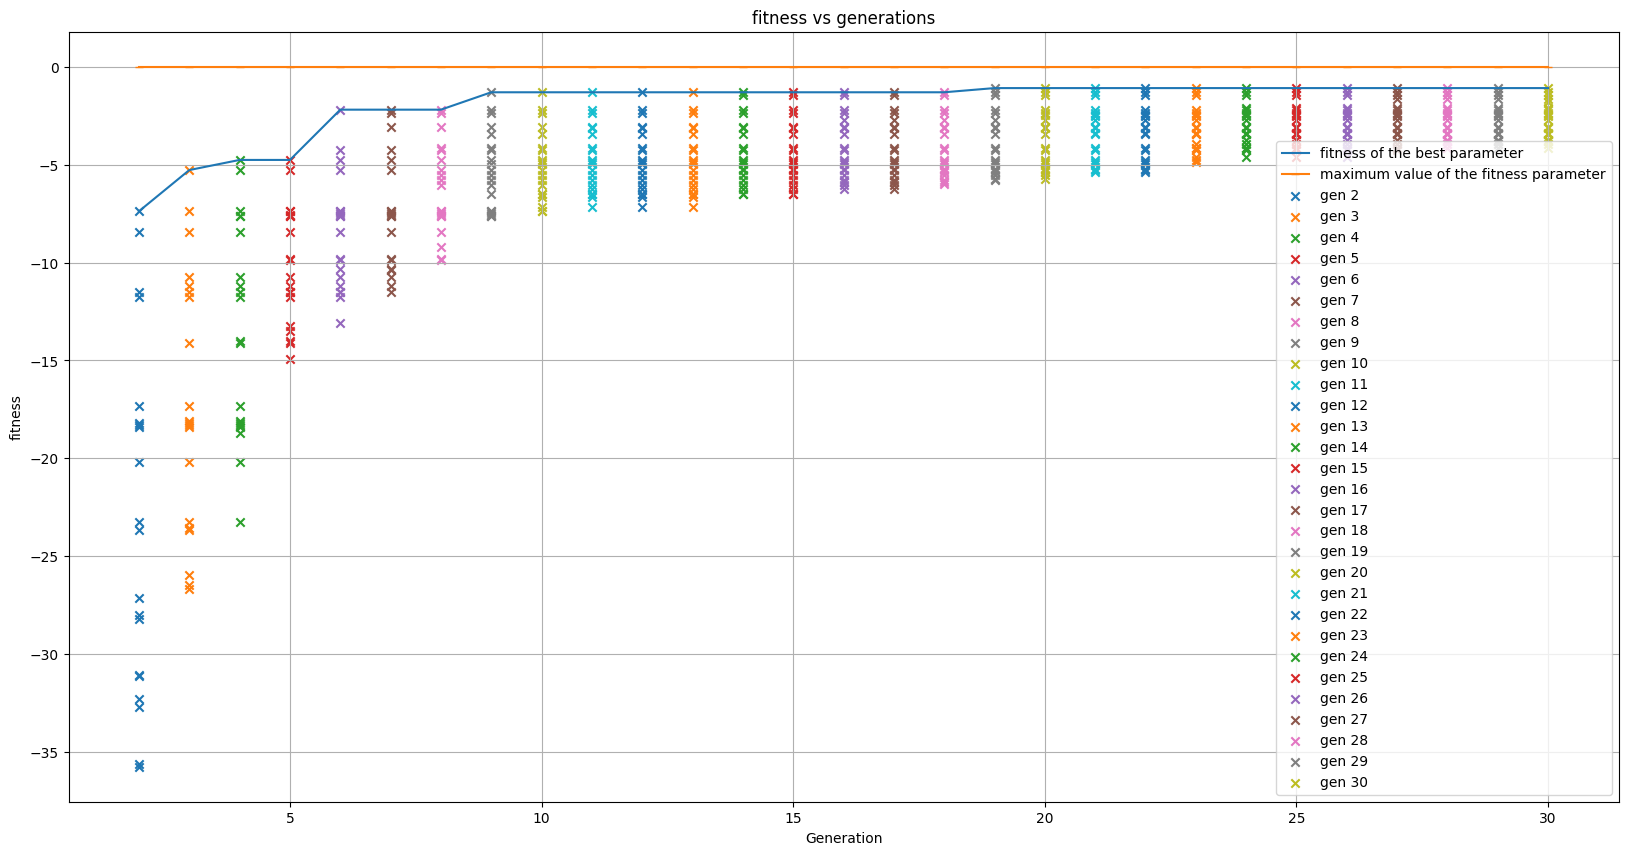

In [43]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(gen[1:],max_val[1:-1], label = "fitness of the best parameter")
plt.plot(gen[1:],np.array(max_val[1:-1])*0,marker = '_' , label = "maximum value of the fitness parameter")
for i in gen[:-1]:
    x_val = [i+1 for j in range(len(fitness_tracker[-1]))]
    plt.scatter(x_val,fitness_tracker[i],marker='x',label = f"gen {i+1}")
    
plt.grid()
plt.xlabel("Generation")
plt.ylabel("fitness")
plt.title("fitness vs generations")
plt.legend()
plt.show()

In [7]:
# # volt_boost.fitness_val = []
# fitness_storage = []
# volt_boost.spawn()
# for gen in range(n_generations):
#     print("//"*50)
#     print(f"generation : {gen}")
    
#     netlist = 'voltage_boost.net'
#     os.chdir(cwd)
#     # fitness_val = []
#     temp_pop = []
#     for i in volt_boost.population:
#         if i not in temp_pop:
#             temp_pop.append(i)

#     if(len(temp_pop) >= 3):
#         volt_boost.population  = temp_pop
#     else:
#         volt_boost.population  = volt_boost.population[:3]

#     fitness_storage = []
#     eval_interface_v2(volt_boost.population , netlist , folder_path , gen , id , req_gain)
#     volt_boost.fitness_score = fitness_storage
#     temp = 1- pow(1.1,max(fitness_storage))
#     print("##"*50)
#     print(f"prob of mutation : {temp}")
#     volt_boost.pipeline(fitness_score = fitness_storage,sa_temp= temp)
#     # fitness_val = []
#     # volt_boost.fitness_val = []
#     os.chdir(cwd)

#     temp_pop = []
#     for i in volt_boost.population:
#         if i not in temp_pop:
#             temp_pop.append(i)

#     if(len(temp_pop) >= 3):
#         volt_boost.population  = temp_pop
#     else:
#         volt_boost.population  = volt_boost.population[:3]

#     fitness_storage = []
#     eval_interface_v2(volt_boost.population , netlist , folder_path , gen , id , req_gain)
#     # for i in range(len(volt_boost.population)):
#     #     param_lst = volt_boost.population[i]
#     #     id = i
#     #     print(f"mutant : {i}")
#     #     fitness_val.append(eval_interface(param_lst , netlist , folder_path , gen , id , req_gain))
#     volt_boost.fitness_score = fitness_storage
#     volt_boost.fitness_sorter()
#     loss_generation.append(max(fitness_storage))
#     pop_storage.append(volt_boost.population)
#     volt_boost.spawn()

initial spawn done sucessfully
////////////////////////////////////////////////////////////////////////////////////////////////////
generation : 0
Successful/Total Simulations: 10/10
####################################################################################################
prob of mutation : 0.6555025921922879
Successful/Total Simulations: 26/26
best individuals spawned sucessfully
////////////////////////////////////////////////////////////////////////////////////////////////////
generation : 1


RunTask #3:Simulation Failed. TimeoutExpired: Command '['E:/LTspice/LTspice.exe', '-Run', '-b', 'e:/Desktop/LTspice/ga_optim_volt_boost/1_2.net']' timed out after 600.0 seconds
RunTask #2:Simulation Failed. TimeoutExpired: Command '['E:/LTspice/LTspice.exe', '-Run', '-b', 'e:/Desktop/LTspice/ga_optim_volt_boost/1_1.net']' timed out after 600.0 seconds
RunTask #4:Simulation Failed. TimeoutExpired: Command '['E:/LTspice/LTspice.exe', '-Run', '-b', 'e:/Desktop/LTspice/ga_optim_volt_boost/1_3.net']' timed out after 600.0 seconds
RunTask #3:Simulation Aborted. Time elapsed: 10:00.0100
RunTask #2:Simulation Aborted. Time elapsed: 10:00.0114
RunTask #4:Simulation Aborted. Time elapsed: 10:00.0093


Successful/Total Simulations: 7/10
####################################################################################################
prob of mutation : 0.7208596591420804
Successful/Total Simulations: 18/18
best individuals spawned sucessfully
////////////////////////////////////////////////////////////////////////////////////////////////////
generation : 2
Successful/Total Simulations: 10/10
####################################################################################################
prob of mutation : 0.6981158860432304
Successful/Total Simulations: 26/26
best individuals spawned sucessfully
////////////////////////////////////////////////////////////////////////////////////////////////////
generation : 3
Successful/Total Simulations: 10/10
####################################################################################################
prob of mutation : 0.7201588540104579
Successful/Total Simulations: 26/26
best individuals spawned sucessfully
/////////////////////////

KeyboardInterrupt: 

In [9]:
volt_boost.best_param

[[470000.0, 33, 220, 56000.0, 0.1, 0.0001],
 [47000.0, 33.0, 220.0, 15000.0, 0.00015, 1e-06],
 [33.0, 330.0, 33.0, 8200.0, 4.7e-06, 3.3e-05],
 [6800.0, 100000.0, 5600.0, 100000.0, 0.1, 2.2e-06],
 [220000.0, 56000.0, 15.0, 22000.0, 3.3e-05, 0.00022],
 [33.0, 330.0, 33.0, 8200.0, 4.7e-06, 3.3e-05],
 [68000.0, 150000.0, 220.0, 2200.0, 0.0015, 3.3e-05],
 [68000.0, 150000.0, 220.0, 2200.0, 0.0015, 1e-05],
 [150000.0, 22.0, 100.0, 10.0, 0.1, 3.3e-06],
 [1500.0, 1000.0, 22000.0, 10.0, 4.7e-05, 0.00022],
 [150000.0, 22.0, 15.0, 10.0, 0.1, 3.3e-06],
 [10.0, 10.0, 100.0, 330.0, 0.01, 3.3e-06],
 [15000.0, 5600.0, 220.0, 10000.0, 0.0047, 4.7e-06],
 [8200.0, 470000.0, 2200.0, 10.0, 0.00047, 0.00022],
 [68.0, 6800.0, 330000.0, 10.0, 4.7e-05, 0.00022],
 [4700.0, 100.0, 100.0, 1000.0, 6.8e-05, 2.2e-07],
 [470000.0, 15.0, 220.0, 10.0, 0.0033, 4.7e-06],
 [4700.0, 10.0, 100.0, 330000.0, 6.8e-05, 2.2e-05],
 [33.0, 15000.0, 100000.0, 10.0, 0.0033, 1e-05],
 [4700.0, 1500.0, 15.0, 6800.0, 2.2e-06, 0.00022]]

In [12]:
volt_boost.fitness_best_param

[-12.805607559597119,
 -5.647732982635498,
 -5.647732982635498,
 -2.5747655367851254,
 -5.647732982635498,
 -5.647732982635498,
 -5.647732982635498,
 -5.647732982635498,
 -12.21223396167159,
 -9.631997411251067,
 -10.763192374408245,
 -8.6930380153656,
 -10.758085864335298,
 -9.851282680556178,
 -10.758085864335298,
 -10.758085864335298,
 -12.34854652222246,
 -11.937997074425219,
 -13.65369177961722,
 -10.495662747472524]

In [63]:
fitness_tracker

[[-6.857969768345356,
  -17.120811667113685,
  -17.18125683152823,
  -17.44437987479705,
  -17.79372217139844,
  -17.977290530398022,
  -18.04370307343197,
  -18.048343170115913,
  -18.112369537455844,
  -18.134911777220623,
  -18.148502388076277,
  -18.149890903401683,
  -18.20944800602966,
  -18.21606677377298,
  -18.222690582989607],
 [-6.857969768345356,
  -15.739069016868598,
  -17.117269633737237,
  -17.120811667113685,
  -17.18125683152823,
  -17.44437987479705,
  -17.79372217139844,
  -17.84120307303965,
  -17.977290530398022,
  -18.004924840012897,
  -18.04370307343197,
  -18.048343170115913,
  -18.112369537455844,
  -18.134911777220623,
  -18.148502388076277],
 [-6.857969768345356,
  -8.37092760950327,
  -14.525566898286343,
  -15.739069016868598,
  -16.334934475584305,
  -17.117269633737237,
  -17.120811667113685,
  -17.18125683152823,
  -17.44437987479705,
  -17.5243386697839,
  -17.79372217139844,
  -17.84120307303965,
  -17.869151405524462,
  -17.92434124509094,
  -17.977